In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from gradvi.tests import toy_data, toy_priors
from gradvi.normal_means import NormalMeans
from gradvi.models import LinearModel

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

In [3]:
X, y, b, s2 = toy_data.get_linear_model(n = 200, p = 20, p_causal = 10, pve = 0.8, rho = 0)
prior = toy_priors.get_ash_scaled()
objtype = 'reparametrize'
lm = LinearModel(X, y, b, s2, prior, objtype = objtype)

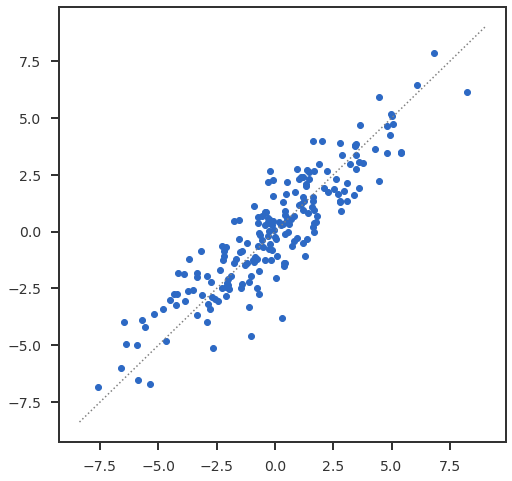

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y, np.dot(X, b))
mpl_utils.plot_diag(ax1)
plt.show()

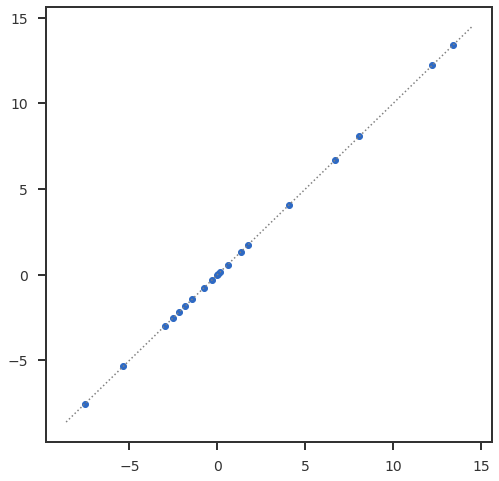

In [5]:
d1 = lm.bgrad

p = b.shape[0]
eps = 1e-8
d2  = np.zeros(p)

for i in range(p):
    b_eps = b.copy()
    b_eps[i] += eps
    lm_eps = LinearModel(X, y, b_eps, s2, prior, objtype = objtype)
    d2[i] = (lm_eps.objective - lm.objective) / eps
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(d1, d2)
mpl_utils.plot_diag(ax1)
plt.show()

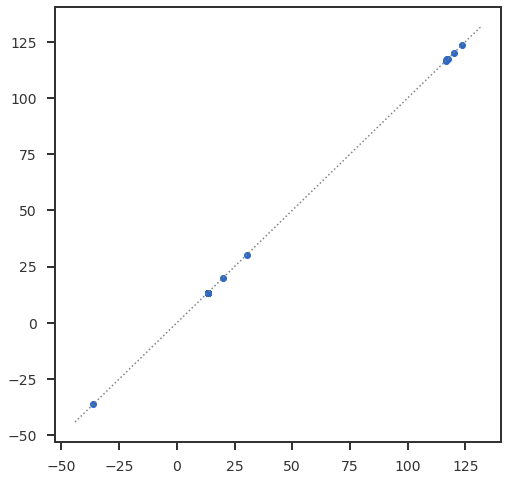

In [6]:
def hessian(lm):
    nm = lm.get_normal_means_model()
    Mb, Mb_bgrad, Mb_wgrad, Mb_sj2grad, Mb_bgrad2 = nm.shrinkage_operator(jac = True, hess = True)
    lj, l_bgrad,  l_wgrad,  l_sj2grad, l_bgrad2  = nm.penalty_operator(jac = True, hess = True)

    r    = lm._y - lm.Xdotv(Mb)
    rTX  = lm.XTdotv(r)

    H = np.dot(lm._X.T, lm._X) * np.outer(Mb_bgrad, Mb_bgrad) / lm._s2
    H[np.diag_indices_from(H)] += l_bgrad2 - (rTX * Mb_bgrad2 / lm._s2)
    return H

def hessian_diag(lm):
    nm = lm.get_normal_means_model()
    Mb, Mb_bgrad, Mb_wgrad, Mb_sj2grad, Mb_bgrad2 = nm.shrinkage_operator(jac = True, hess = True)
    lj, l_bgrad,  l_wgrad,  l_sj2grad, l_bgrad2  = nm.penalty_operator(jac = True, hess = True)

    r    = lm._y - lm.Xdotv(Mb)
    rTX  = lm.XTdotv(r)
    XTX  = np.dot(lm._X.T, lm._X)
    Hdiag = (np.diag(XTX) * np.square(Mb_bgrad) - rTX * Mb_bgrad2) / lm._s2 + l_bgrad2
    return Hdiag

lm = LinearModel(X, y, b, s2, prior, objtype = objtype)
d1 = np.diag(hessian(lm))
#d1 = hessian_diag(lm)

p = b.shape[0]
eps = 1e-9
d2  = np.zeros(p)

for i in range(p):
    b_eps = b.copy()
    b_eps[i] += eps
    lm_eps = LinearModel(X, y, b_eps, s2, prior, objtype = objtype)
    d2[i] = (lm_eps.bgrad[i] - lm.bgrad[i]) / eps
    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(d1, d2)
mpl_utils.plot_diag(ax1)
plt.show()

In [7]:
import numdifftools

def objective_function(inx):
    lm = LinearModel(X, y, inx, s2, prior, objtype = objtype)
    return lm.objective

H2 = numdifftools.Hessian(objective_function)(b)

lm = LinearModel(X, y, b, s2, prior, objtype = objtype)
H1 = hessian(lm)
np.allclose(H1, H2)

True